In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from boltons.iterutils import chunked
import fuzzymatcher

pol_df = pd.read_csv(r'/home/mayoubi/police_killings.csv')
top_100_df = pd.read_csv(r'/home/mayoubi/top_100__cities.csv')

In [2]:
census_names = top_100_df['top_100_cities'].tolist()

In [3]:
def transform_cities_to_urls(cities):
    
    """Takes list of city name slug strings and outputs a list of string URLs.
    
    In each of the URLs there is a max of 6 cities, because the census quickfacts 
    site will fail request with more than 6 cities.
    
    Example city name format: losangelescitycalifornia"""
    
    url_prefix = 'https://www.census.gov/quickfacts/fact/csv/'
    url_suffix = '/RHI125218'
    ret = [] # make return variable
    for chunk in chunked(cities, 6):  # iterate over chunks of cities
        #print(chunk)
        url = url_prefix + ','.join(chunk) + url_suffix
        #print(url)    # create url
        ret.append(url)# add url to return variable
    return ret    # return return variable
    
    
#transform_cities_to_urls(census_names)

In [4]:
df_list = []
for url in transform_cities_to_urls(census_names): 
    census_df = pd.read_csv(url)
    df_list.append(census_df.transpose())
    #print(df_list)
    
census_df = pd.concat(df_list, sort=False)

In [5]:
new_header = census_df.iloc[0] #grab the first row for the header
census_df = census_df[1:] #take the data less the header row
census_df.columns = new_header #set the header row as the df header

census_df.reset_index(level=0, inplace=True)

census_df = census_df.rename(columns={'index':'City_State'})
census_df = census_df.drop(census_df.iloc[:, 17:84], axis = 1)
#census_df.head()

In [6]:
#needs to be updated by dropping columns through iloc

census_df = census_df[~census_df.City_State.str.contains('Note')]
census_df = census_df[~census_df.City_State.str.contains('Fact')]
census_df = census_df[census_df.columns.drop(list(census_df.filter(regex='estimates')))]
census_df = census_df[census_df.columns.drop(list(census_df.filter(regex='persons')))]
census_df = census_df[census_df.columns.drop(list(census_df.filter(regex='Persons')))]
pd.set_option('display.max_rows', None)
census_df = census_df.reset_index(drop=True)
census_df.head()

Fact,City_State,"Population, Census, April 1, 2010","White alone, percent","Black or African American alone, percent","American Indian and Alaska Native alone, percent","Asian alone, percent","Native Hawaiian and Other Pacific Islander alone, percent","Two or More Races, percent","Hispanic or Latino, percent","White alone, not Hispanic or Latino, percent"
0,"Los Angeles city, California","3,792,621",52.4%,8.9%,0.7%,11.6%,0.2%,3.6%,48.6%,28.5%
1,"Phoenix city, Arizona","1,445,632",72.3%,6.9%,2.1%,3.7%,0.2%,3.8%,42.6%,43.0%
2,"Houston city, Texas","2,099,451",57.6%,22.5%,0.3%,6.9%,0.1%,2.1%,44.8%,24.6%
3,"Chicago city, Illinois","2,695,598",49.4%,30.1%,0.3%,6.4%,0.0%,2.7%,29.0%,32.8%
4,"Las Vegas city, Nevada","583,756",62.2%,12.2%,0.9%,6.6%,0.8%,4.9%,32.9%,44.2%


In [7]:
def change_string(strings):
    
    """Takes columns and outputs updated column name."""
    
    return strings.lower().replace(',', '_').lower().replace(' ','_').lower().replace('__','_').lower().replace("'",'').lower().replace('old_value', 'new_value')
    
census_df.columns = census_df.columns.map(lambda strings: change_string(strings))
#census_df

In [8]:
census_df.dtypes

Fact
city_state                                                  object
population_census_april_1_2010                              object
white_alone_percent                                         object
black_or_african_american_alone_percent                     object
american_indian_and_alaska_native_alone_percent             object
asian_alone_percent                                         object
native_hawaiian_and_other_pacific_islander_alone_percent    object
two_or_more_races_percent                                   object
hispanic_or_latino_percent                                  object
white_alone_not_hispanic_or_latino_percent                  object
dtype: object

In [9]:
def update_strings_in_columns(strings):
    
    """Takes columns that are string types and outputs updated string."""
    
    for ch in ['%',',']:
        strings = strings.map(lambda x: x.replace(ch, ''))
    return strings

census_df = census_df.apply(update_strings_in_columns)
census_df.head()

Fact,city_state,population_census_april_1_2010,white_alone_percent,black_or_african_american_alone_percent,american_indian_and_alaska_native_alone_percent,asian_alone_percent,native_hawaiian_and_other_pacific_islander_alone_percent,two_or_more_races_percent,hispanic_or_latino_percent,white_alone_not_hispanic_or_latino_percent
0,Los Angeles city California,3792621,52.4,8.9,0.7,11.6,0.2,3.6,48.6,28.5
1,Phoenix city Arizona,1445632,72.3,6.9,2.1,3.7,0.2,3.8,42.6,43.0
2,Houston city Texas,2099451,57.6,22.5,0.3,6.9,0.1,2.1,44.8,24.6
3,Chicago city Illinois,2695598,49.4,30.1,0.3,6.4,0.0,2.7,29.0,32.8
4,Las Vegas city Nevada,583756,62.2,12.2,0.9,6.6,0.8,4.9,32.9,44.2


In [10]:
cols=[i for i in census_df.columns if i not in ['city_state']]
for col in cols:
    census_df[col]=pd.to_numeric(census_df[col])

In [11]:
def transform_percent_to_value(population, percent):
    
    """Returns the difference between population and percent"""
    
    return population*(percent/100)

census_df['black_pop'] = transform_percent_to_value(census_df['population_census_april_1_2010'], census_df['black_or_african_american_alone_percent'])
census_df['white_pop'] = transform_percent_to_value(census_df['population_census_april_1_2010'], census_df['white_alone_not_hispanic_or_latino_percent'])
census_df['hispanic_pop'] = transform_percent_to_value(census_df['population_census_april_1_2010'], census_df['hispanic_or_latino_percent'])

In [12]:
pol_df.columns = pol_df.columns.map(lambda strings: change_string(strings))

In [13]:
pol_df['freq_of_city'] = pol_df.groupby('city_and_state')['city_and_state'].transform('count')
pol_df.nlargest(100, 'freq_of_city').head()

,id,city_and_state,victims_name,victims_age,victims_gender,victims_race,url_of_image_of_victim,date_of_incident_(month/day/year),street_address_of_incident,city,...,body_camera_(source:_wapo),wapo_id_(if_included_in_wapo_database),off-duty_killing?,geography_(via_trulia_methodology_based_on_zipcode_population_density:_http://jedkolko.com/wp-content/uploads/2015/05/full-zcta-urban-suburban-rural-classification.xlsx_),id.1,unnamed:_29,unnamed:_30,unnamed:_31,unnamed:_32,freq_of_city
56,Los Angeles_CA,Los Angeles city California,Name withheld by police,NaN,Male,Hispanic,NaN,16/12/2019,3600 4th St,Los Angeles,...,No,5292,NaN,Urban,7610,NaN,NaN,NaN,NaN,115.0
132,Los Angeles_CA,Los Angeles city California,Jessica Ann Beedles,42,Female,White,NaN,20/11/2019,5000 Nora Lynn Dr,Los Angeles,...,No,5263,NaN,Urban,7535,NaN,NaN,NaN,NaN,115.0
137,Los Angeles_CA,Los Angeles city California,Alex Flores,34,Male,Hispanic,NaN,19/11/2019,28th St and S Central Ave,Los Angeles,...,No,5199,NaN,Urban,7531,NaN,NaN,NaN,NaN,115.0
152,Los Angeles_CA,Los Angeles city California,Omar Enrique Garcia,37,Male,Hispanic,NaN,13/11/2019,4211 Dozier St,Los Angeles,...,No,5203,NaN,Urban,7514,NaN,NaN,NaN,NaN,115.0
411,Los Angeles_CA,Los Angeles city California,Carlos Torres,39,Male,Hispanic,NaN,19/08/2019,Ottoman St and Bartee Ave,Los Angeles,...,No,4968,NaN,Urban,7255,NaN,NaN,NaN,NaN,115.0


In [14]:
pol_df['victims_gender'] = pol_df['victims_gender'].astype(str)
pol_df['victims_race'] = pol_df['victims_race'].astype(str)
pol_df['victims_age'] = pol_df['victims_age'].astype(str)

pol_df = pol_df[~pol_df.victims_race.str.contains('Unknown')]
pol_df = pol_df[~pol_df.victims_age.str.contains('Unknown')]

pol_df = pol_df.dropna(subset=['freq_of_city'])

In [15]:
pol_sql_df = pol_df.groupby(['id']).count().reset_index().sort_values(['freq_of_city'], ascending=[False]).head(100)
pol_sql_df = pol_sql_df[['id','freq_of_city']]
pol_sql_df.head()

,id,freq_of_city
1596,Los Angeles_CA,107
2163,Phoenix_AZ,96
1268,Houston_TX,83
468,Chicago_IL,75
1921,New York_NY,60


In [16]:
pol_df = pol_sql_df.merge(pol_df[['city_and_state', 'id', 'victims_race']], how = 'left', left_on = 'id', right_on = 'id')
pol_df.head()

,id,freq_of_city,city_and_state,victims_race
0,Los Angeles_CA,107,Los Angeles city California,Hispanic
1,Los Angeles_CA,107,Los Angeles city California,White
2,Los Angeles_CA,107,Los Angeles city California,Hispanic
3,Los Angeles_CA,107,Los Angeles city California,Hispanic
4,Los Angeles_CA,107,Los Angeles city California,Hispanic


In [17]:
census_df.head()

Fact,city_state,population_census_april_1_2010,white_alone_percent,black_or_african_american_alone_percent,american_indian_and_alaska_native_alone_percent,asian_alone_percent,native_hawaiian_and_other_pacific_islander_alone_percent,two_or_more_races_percent,hispanic_or_latino_percent,white_alone_not_hispanic_or_latino_percent,black_pop,white_pop,hispanic_pop
0,Los Angeles city California,3792621,52.4,8.9,0.7,11.6,0.2,3.6,48.6,28.5,337543.269,1080896.985,1843213.806
1,Phoenix city Arizona,1445632,72.3,6.9,2.1,3.7,0.2,3.8,42.6,43.0,99748.608,621621.760,615839.232
2,Houston city Texas,2099451,57.6,22.5,0.3,6.9,0.1,2.1,44.8,24.6,472376.475,516464.946,940554.048
3,Chicago city Illinois,2695598,49.4,30.1,0.3,6.4,0.0,2.7,29.0,32.8,811374.998,884156.144,781723.420
4,Las Vegas city Nevada,583756,62.2,12.2,0.9,6.6,0.8,4.9,32.9,44.2,71218.232,258020.152,192055.724


In [18]:
left_on = ['city_state']

right_on = ['city_and_state']

matched_results = fuzzymatcher.fuzzy_left_join(census_df,
                                            pol_df,
                                            left_on,
                                            right_on,
                                            left_id_col='city_state',
                                            right_id_col='city_and_state')

cols = [
    'best_match_score', 'city_state', 'city_and_state', 'victims_race', 
    'population_census_april_1_2010', 'white_pop', 'black_pop', 'hispanic_pop'
]

merged_df = matched_results[cols].sort_values(by=['best_match_score'], ascending=False)
merged_df.head()

,best_match_score,city_state,city_and_state,victims_race,population_census_april_1_2010,white_pop,black_pop,hispanic_pop
1712,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036
1718,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036
1725,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036
1723,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,White,97618,32018.704,2928.54,58766.036
1722,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036


In [19]:
def clean_dataframe(dataf):
    return (dataf
           .assign(black=lambda d: (d['victims_race']=='Black').astype(np.int))
           .assign(white=lambda d: (d['victims_race']=='White').astype(np.int))
           .assign(hispanic=lambda d: (d['victims_race']=='Hispanic').astype(np.int)))

clean_df = merged_df.pipe(clean_dataframe)
clean_df.head()

,best_match_score,city_state,city_and_state,victims_race,population_census_april_1_2010,white_pop,black_pop,hispanic_pop,black,white,hispanic
1712,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036,0,0,1
1718,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036,0,0,1
1725,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036,0,0,1
1723,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,White,97618,32018.704,2928.54,58766.036,0,1,0
1722,0.664363,Las Cruces city New Mexico,Las Cruces city New Mexico,Hispanic,97618,32018.704,2928.54,58766.036,0,0,1


In [20]:
normal_df = pd.pivot_table(clean_df,index=['city_state'],values=['black', 
                                                             'white', 'hispanic'], aggfunc=np.sum)
normal_df = normal_df.merge(clean_df[['population_census_april_1_2010', 'white_pop', 'black_pop', 
                            'hispanic_pop', 'city_state']], 
                  how = 'left',left_on = 'city_state', right_on = 'city_state')

normal_df = normal_df.drop_duplicates()
normal_df.reset_index(level=0, inplace=True)
normal_df = normal_df.drop(columns=['index'])
normal_df.head()

,city_state,black,hispanic,white,population_census_april_1_2010,white_pop,black_pop,hispanic_pop
0,Akron city Ohio,3,0,5,199110,116479.350,59932.110,4778.640
1,Albuquerque city New Mexico,3,29,17,545852,215065.688,17467.264,267467.480
2,Amarillo city Texas,1,5,3,190695,104500.860,12585.870,61594.485
3,Anaheim city California,3,7,4,336265,83393.720,8406.625,181583.100
4,Arlington city Texas,6,0,4,365438,142886.258,82223.550,106707.896


In [21]:
normal_df['black_avg_rate_per_100000'] = (normal_df['black']/normal_df['black_pop'])*100000
normal_df['white_avg_rate_per_100000'] = (normal_df['white']/normal_df['white_pop'])*100000
normal_df['hispanic_avg_rate_per_100000'] = (normal_df['hispanic']/normal_df['white_pop'])*100000

normal_df.sort_values(by=['black_avg_rate_per_100000'], ascending = False).head()

,city_state,black,hispanic,white,population_census_april_1_2010,white_pop,black_pop,hispanic_pop,black_avg_rate_per_100000,white_avg_rate_per_100000,hispanic_avg_rate_per_100000
75,Salt Lake City city Utah,3,3,7,186440,121931.760,4288.120,40271.040,69.960729,5.740916,2.460393
70,Reno city Nevada,3,5,6,225221,137610.031,6080.967,55629.587,49.334259,4.360147,3.633456
94,Tempe city Arizona,4,7,2,161719,91856.392,10511.735,36225.056,38.052710,2.177312,7.620591
3,Anaheim city California,3,7,4,336265,83393.720,8406.625,181583.100,35.686140,4.796524,8.393917
67,Pueblo city Colorado,1,13,3,106595,46262.230,2984.660,54576.640,33.504654,6.484772,28.100677


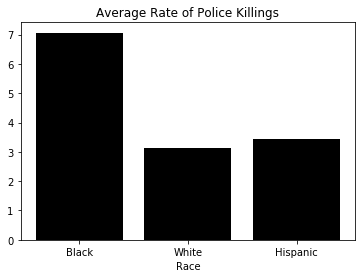

In [22]:
black_avg_rate = (normal_df['black'].sum()/normal_df['black_pop'].sum())*100000
white_avg_rate = (normal_df['white'].sum()/normal_df['white_pop'].sum())*100000
hispanic_avg_rate = (normal_df['hispanic'].sum()/normal_df['hispanic_pop'].sum())*100000

x = ['Black', 'White', 'Hispanic']
avg = [black_avg_rate, white_avg_rate, hispanic_avg_rate]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, avg, color='black')
plt.xlabel('Race')
plt.ylabel('')
plt.title('Average Rate of Police Killings')

plt.xticks(x_pos, x)

plt.show()